In [36]:
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer
import warnings
warnings.filterwarnings('ignore') #Suppress some warnings for cleaner output


# 1. Load Data
data = pd.read_csv('c:/Users/karan/Desktop/mini project/Dataset11-Weather-Data.csv')
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data.set_index('Date/Time', inplace=True)

# 2. Feature Engineering
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofweek'] = df.index.dayofweek  # Day of the week

    # Cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)

    # Interaction terms (example - can add more)
    df['Temp_Hum_interaction'] = df['Temp_C'] * df['Rel Hum_%']
    df['Wind_Speed_Visibility'] = df['Wind Speed_km/h'] * df['Visibility_km']
    df['Temp_Press_interaction'] = df['Temp_C'] * df['Press_kPa']

    # Lagged features (using shift - handle missing values carefully)
    df['Temp_C_lag1'] = df['Temp_C'].shift(1)
    df['Temp_C_lag24'] = df['Temp_C'].shift(24)
    df.fillna(method='bfill', inplace=True)  # Fill missing values after shift

    # Rolling statistics (example - rolling mean)
    window_size = 3  #Can try different window sizes
    df['Temp_C_rolling_mean'] = df['Temp_C'].rolling(window=window_size,center=True).mean()
    df['Temp_C_rolling_std'] = df['Temp_C'].rolling(window=window_size,center=True).std()

    # Handle any newly created NaNs from rolling calculations
    df.fillna(method='bfill', inplace=True)
    return df

data = create_features(data)


# 3. Preprocessing and Column Transformation
# Identify numerical and categorical columns for preprocessing
numerical_cols = ['Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
                   'Visibility_km', 'Press_kPa', 'hour', 'month', 'dayofyear', 'dayofweek',
                   'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos',
                   'Temp_Hum_interaction', 'Wind_Speed_Visibility', 'Temp_Press_interaction',
                   'Temp_C_lag1', 'Temp_C_lag24', 'Temp_C_rolling_mean','Temp_C_rolling_std']  # Include all engineered numerical features
categorical_cols = ['Weather']

# Create separate imputers for numerical and categorical features
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')


# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', numerical_imputer), ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', categorical_imputer), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ],
    remainder='passthrough'  # This is important to handle any columns NOT specified
)


# 4. Define features (X) and target (y)
X = data.drop('Temp_C', axis=1)
y = data['Temp_C']


# 5. Split data into training and test sets (Time series split)
test_size = 0.3  # 30% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# Imputation is now handled within the preprocessor pipeline


# 6. Define and Train Base Models

# Linear Regression
lr = LinearRegression()

# Random Forest
rf = RandomForestRegressor(random_state=42)

# SVM
svm = SVR()

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)


# 7. Train Base Models
# Create pipelines including preprocessing
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', lr)])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', svm)])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])


#Fit the models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)


# 8. Define function to calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculates and prints MAE, MSE, RMSE, and R-squared."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Metrics for {dataset_name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")
    return mae, mse, rmse, r2


# 9. Evaluate the Models

# Make predictions on the training and test sets
lr_train_preds = lr_pipeline.predict(X_train)
lr_test_preds = lr_pipeline.predict(X_test)

rf_train_preds = rf_pipeline.predict(X_train)
rf_test_preds = rf_pipeline.predict(X_test)

svm_train_preds = svm_pipeline.predict(X_train)
svm_test_preds = svm_pipeline.predict(X_test)

xgb_train_preds = xgb_pipeline.predict(X_train)
xgb_test_preds = xgb_pipeline.predict(X_test)

# Calculate and print metrics for each model
print("Linear Regression Metrics:")
calculate_metrics(y_train, lr_train_preds, "Training Data")
calculate_metrics(y_test, lr_test_preds, "Test Data")

print("\nRandom Forest Metrics:")
calculate_metrics(y_train, rf_train_preds, "Training Data")
calculate_metrics(y_test, rf_test_preds, "Test Data")

print("\nSVM Metrics:")
calculate_metrics(y_train, svm_train_preds, "Training Data")
calculate_metrics(y_test, svm_test_preds, "Test Data")

print("\nXGBoost Metrics:")
calculate_metrics(y_train, xgb_train_preds, "Training Data")
calculate_metrics(y_test, xgb_test_preds, "Test Data")

Linear Regression Metrics:
Metrics for Training Data:
  MAE: 0.0585
  MSE: 0.0063
  RMSE: 0.0793
  R-squared: 1.0000
Metrics for Test Data:
  MAE: 0.0811
  MSE: 0.0118
  RMSE: 0.1085
  R-squared: 0.9998

Random Forest Metrics:
Metrics for Training Data:
  MAE: 0.0137
  MSE: 0.0005
  RMSE: 0.0232
  R-squared: 1.0000
Metrics for Test Data:
  MAE: 0.0368
  MSE: 0.0033
  RMSE: 0.0579
  R-squared: 1.0000

SVM Metrics:
Metrics for Training Data:
  MAE: 0.2744
  MSE: 0.3514
  RMSE: 0.5928
  R-squared: 0.9977
Metrics for Test Data:
  MAE: 4.4876
  MSE: 40.1138
  RMSE: 6.3335
  R-squared: 0.4432

XGBoost Metrics:
Metrics for Training Data:
  MAE: 0.0339
  MSE: 0.0019
  RMSE: 0.0434
  R-squared: 1.0000
Metrics for Test Data:
  MAE: 0.0687
  MSE: 0.0080
  RMSE: 0.0894
  R-squared: 0.9999


(0.06874279033941003,
 0.007987355833212214,
 0.0893720081077527,
 0.9998891217343457)

In [37]:

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model", display=True):
    """
    Trains the given model, makes predictions and displays r2 score along with a graph showing predictions vs actual values.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = r2_score(y_test, y_pred)

    if display:
        print(f"{model_name} Accuracy (R-squared): {accuracy:.4f}")

        # Create a plot
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
        plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.title(f'{model_name} - Actual vs Predicted Temperature')
        plt.legend()
        plt.grid(True)
        plt.show()

    return accuracy, y_pred #Return predictions as well

print("Functions Ready")


Functions Ready


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Trains the given model, makes predictions, displays metrics (MSE, MAE, R-squared) and generates training and testing plots.
    """
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Output Metrics
    print(f"{model_name} - Training Metrics:")
    print(f"  MSE: {mse_train:.4f}")
    print(f"  MAE: {mae_train:.4f}")
    print(f"  R-squared: {r2_train:.4f}")

    print(f"{model_name} - Testing Metrics:")
    print(f"  MSE: {mse_test:.4f}")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  R-squared: {r2_test:.4f}")

    # Plot Training Data
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train.values, label='Actual', color='blue')
    plt.plot(y_train.index, y_train_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'{model_name} - Training: Actual vs Predicted Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Testing Data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
    plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'{model_name} - Testing: Actual vs Predicted Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()


print("Functions Ready")


Functions Ready


Linear Regression Model:
Linear Regression - Training Metrics:
  MSE: 0.0063
  MAE: 0.0585
  R-squared: 1.0000
Linear Regression - Testing Metrics:
  MSE: 0.0118
  MAE: 0.0811
  R-squared: 0.9998


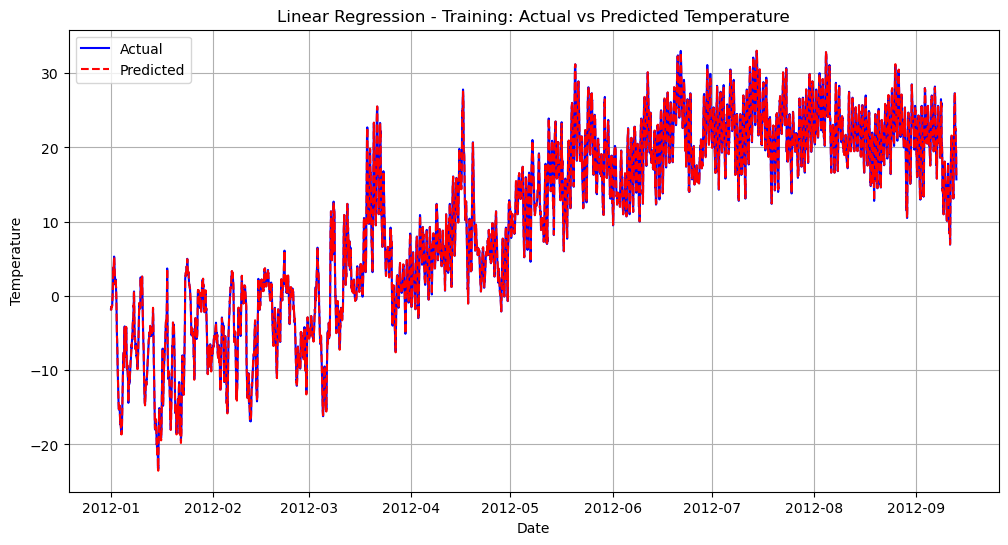

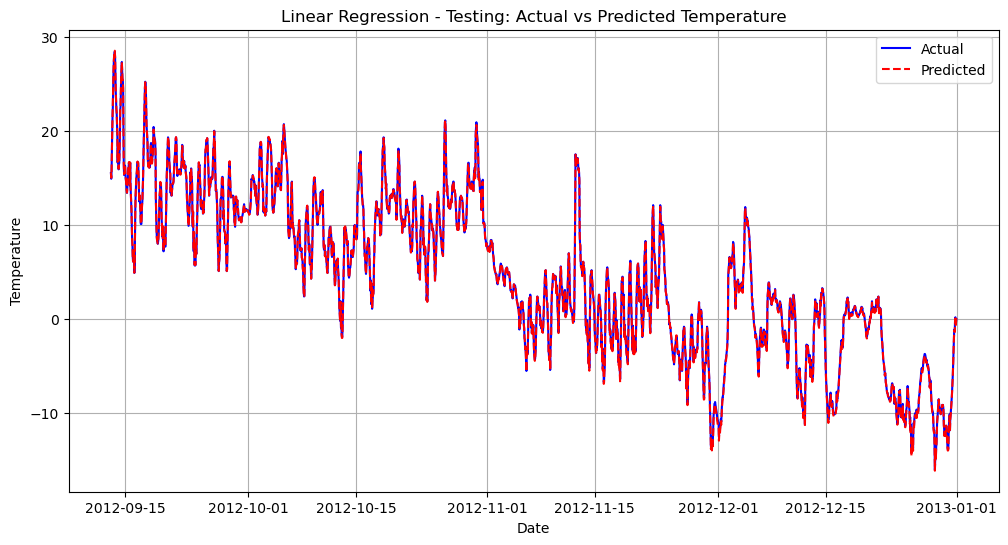

In [39]:
# Create and train the Linear Regression model
lr_model = LinearRegression()
print("Linear Regression Model:")

# Preprocess the data using the pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Now, call train_and_evaluate with the preprocessed data
train_and_evaluate(lr_model, X_train_processed, y_train, X_test_processed, y_test, model_name="Linear Regression")

Optimized SVM - Training Metrics:
  MSE: 0.0065
  MAE: 0.0620
  R-squared: 1.0000
Optimized SVM - Testing Metrics:
  MSE: 0.0120
  MAE: 0.0838
  R-squared: 0.9998


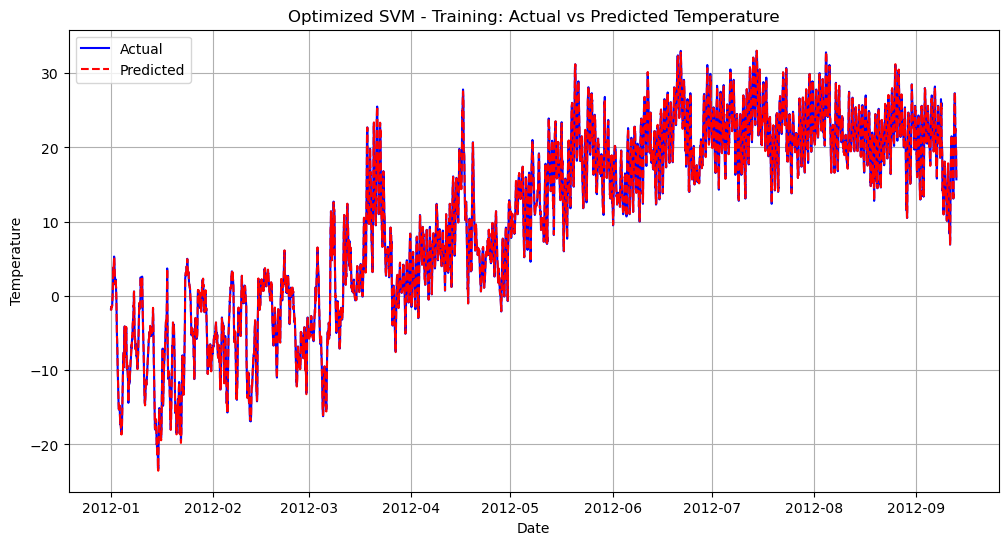

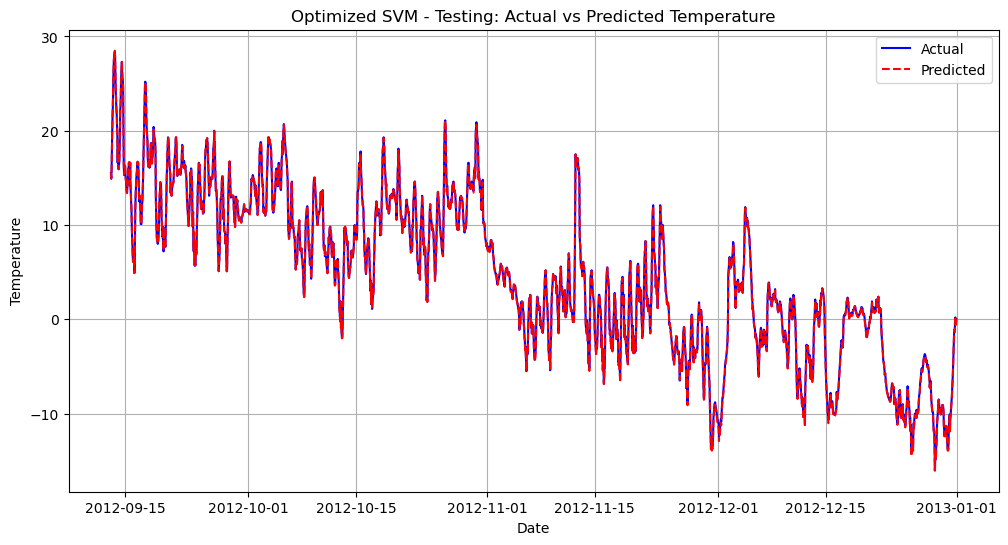

In [40]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define SVM model
svm = SVR()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': ['scale', 0.1, 1, 10],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly']  # Kernel types
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV to find best parameters
grid_search = GridSearchCV(svm, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_processed, y_train)

# Get the best model
best_svm = grid_search.best_estimator_

# Evaluate the optimized SVM model
train_and_evaluate(best_svm, X_train_processed, y_train, X_test_processed, y_test, model_name="Optimized SVM")


Random Forest Model:
Random Forest - Training Metrics:
  MSE: 0.0005
  MAE: 0.0137
  R-squared: 1.0000
Random Forest - Testing Metrics:
  MSE: 0.0033
  MAE: 0.0368
  R-squared: 1.0000


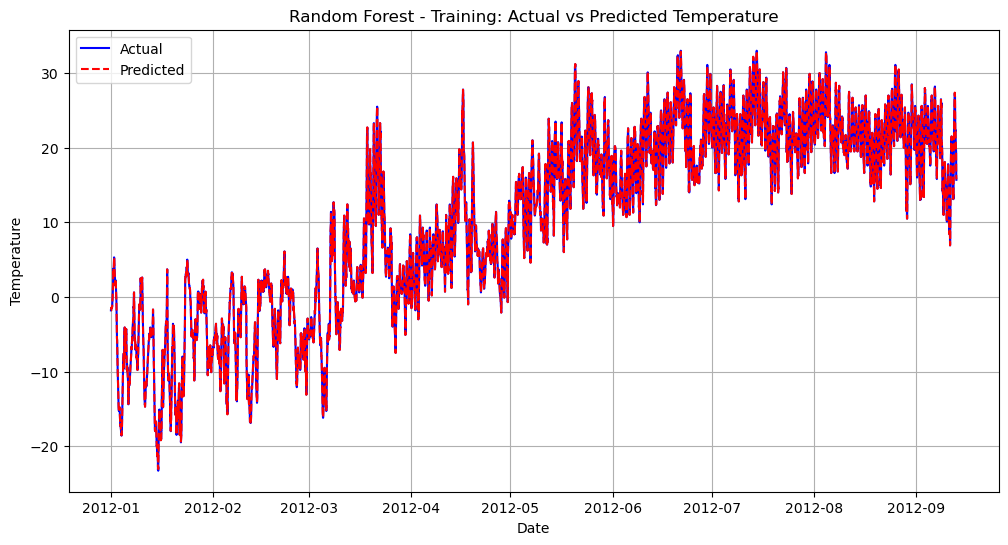

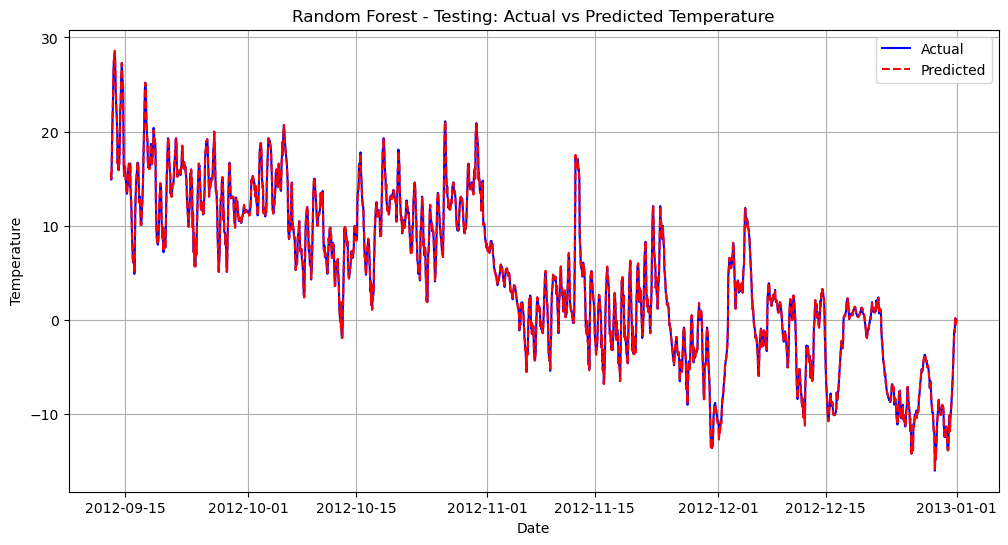

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
print("Random Forest Model:")
train_and_evaluate(rf_model, X_train_processed, y_train, X_test_processed, y_test, model_name="Random Forest")

XGBoost Model:
XGBoost - Training Metrics:
  MSE: 0.0019
  MAE: 0.0339
  R-squared: 1.0000
XGBoost - Testing Metrics:
  MSE: 0.0080
  MAE: 0.0687
  R-squared: 0.9999


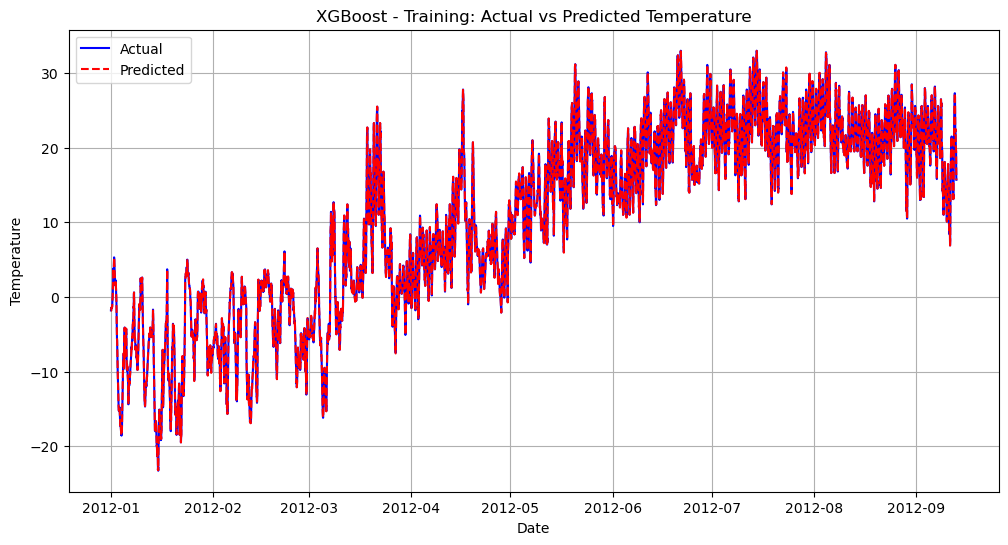

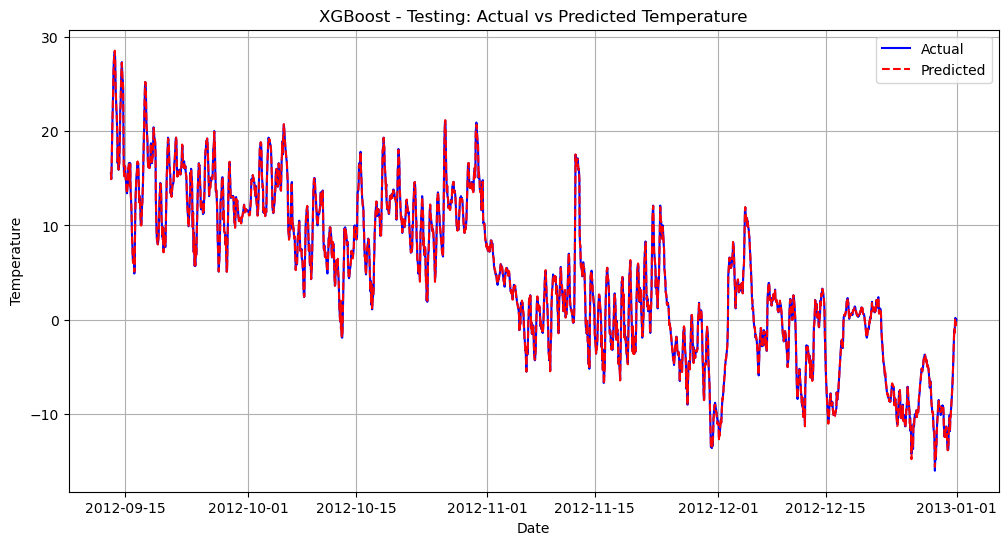

In [42]:
import xgboost as xgb

# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
print("XGBoost Model:")
train_and_evaluate(xgb_model, X_train_processed, y_train, X_test_processed, y_test, model_name="XGBoost")



# xai


In [43]:
import numpy as np

def add_features(df):
    df = df.copy()
    df['hour'] = df['Date/Time'].dt.hour
    df['month'] = df['Date/Time'].dt.month
    df['dayofyear'] = df['Date/Time'].dt.dayofyear
    df['dayofweek'] = df['Date/Time'].dt.dayofweek

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    df['Temp_Hum_interaction'] = df['Temp_C'] * df['Rel Hum_%']
    df['Temp_Press_interaction'] = df['Temp_C'] * df['Press_kPa']
    df['Wind_Speed_Visibility'] = df['Wind Speed_km/h'] * df['Visibility_km']

    df['Temp_C_lag1'] = df['Temp_C'].shift(1)
    df['Temp_C_lag24'] = df['Temp_C'].shift(24)
    df['Temp_C_rolling_mean'] = df['Temp_C'].rolling(window=24).mean()
    df['Temp_C_rolling_std'] = df['Temp_C'].rolling(window=24).std()

    df = df.dropna()
    return df


In [44]:

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df_fe = add_features(df)

X = df_fe.drop(columns=['Temp_C'])
y = df_fe['Temp_C']

from sklearn.model_selection import train_test_split
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_transformed = preprocessor.transform(X_train_fe)


In [45]:

def get_feature_names(preprocessor, numeric_features, categorical_features):
    output_features = []
    for name, trans, columns in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(columns)
        elif name == 'cat':
            encoder = trans.named_steps['encoder']
            categories = encoder.categories_
            for i, cat in enumerate(categories):
                output_features.extend([f"{categorical_features[i]}_{c}" for c in cat])
    return output_features

feature_names = get_feature_names(preprocessor, numerical_cols, categorical_cols)
print("Feature names after transformation:")


Feature names after transformation:


100%|===================| 6124/6132 [00:13<00:00]        

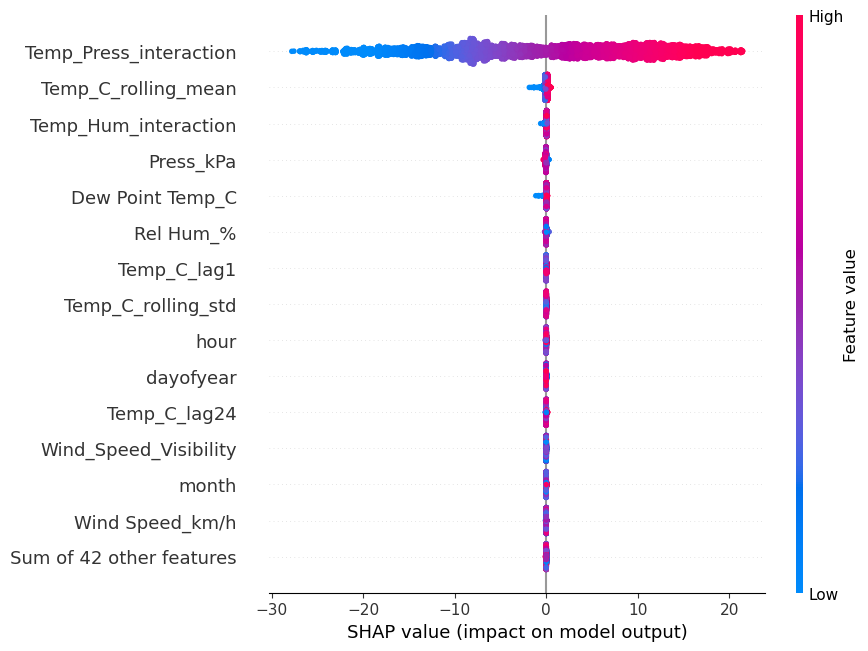

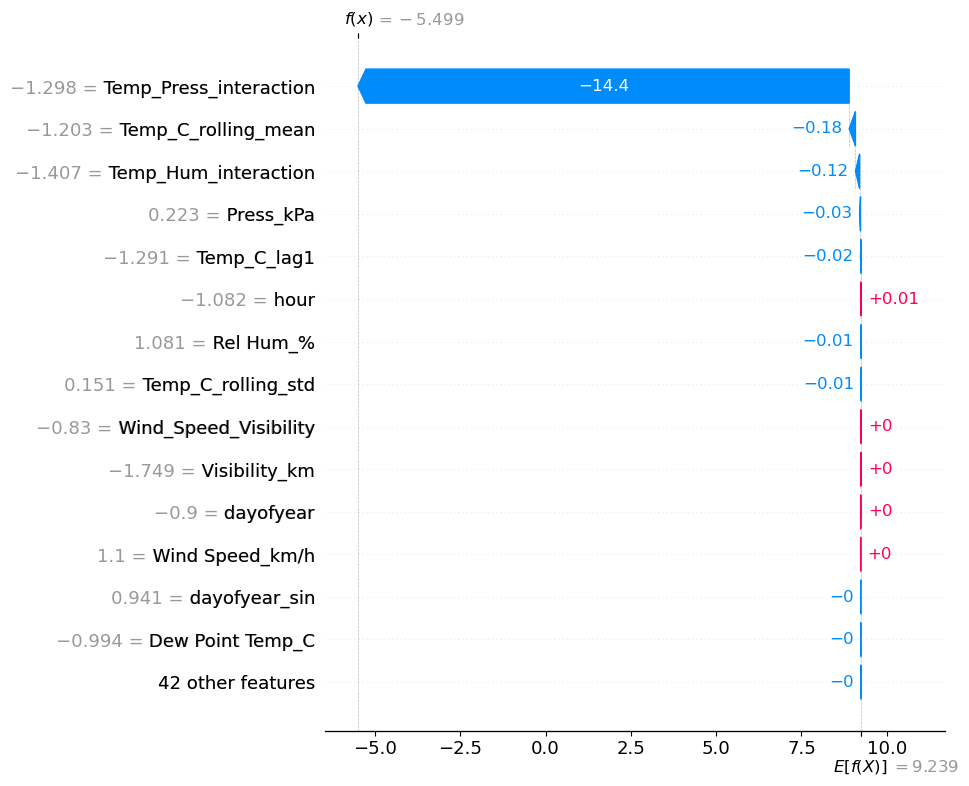

In [46]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_pipeline.named_steps['model'], X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_train_transformed)

shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.waterfall(shap_values[0], max_display=15)


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Trains the given model, makes predictions, displays metrics (MSE, MAE, R-squared) and generates training and testing plots.
    """
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    mse_train = mean_squared_error(y_train, y_train_pred)  # Calculate mse_train here
    mae_train = mean_absolute_error(y_train, y_train_pred)  # Calculate mae_train here
    r2_train = r2_score(y_train, y_train_pred)  # Calculate r2_train here

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Output Metrics
    print(f"{model_name} - Training Metrics:")
    print(f"  MSE: {mse_train:.4f}")
    print(f"  MAE: {mae_train:.4f}")
    print(f"  R-squared: {r2_train:.4f}")

    print(f"{model_name} - Testing Metrics:")
    print(f"  MSE: {mse_test:.4f}")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  R-squared: {r2_test:.4f}")

    # Plot Training Data
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train.values, label='Actual', color='blue')
    plt.plot(y_train.index, y_train_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'{model_name} - Training: Actual vs Predicted Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Testing Data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
    plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'{model_name} - Testing: Actual vs Predicted Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the metrics
    return {
        'train': {'mse': mse_train, 'mae': mae_train, 'r2': r2_train},
        'test': {'mse': mse_test, 'mae': mae_test, 'r2': r2_test},
    } # Moved return statement after calculations

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('c:/Users/karan/Desktop/mini project/Dataset11-Weather-Data.csv')

# Define the target variable (replace with the correct one)
target_column = 'Temp_C'  # Set your correct target variable

# Drop non-numeric columns (except target)
X = df.drop(columns=[target_column, 'Date/Time'])

# Convert categorical column ('Weather') to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['Weather'], drop_first=True)

# Define target variable
y = df[target_column]

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (7027, 54), X_test shape: (1757, 54)
y_train shape: (7027,), y_test shape: (1757,)


In [49]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # You can change the model
from sklearn.metrics import accuracy_score

# Load dataset (replace 'your_dataset.csv' with your actual dataset file)
df = pd.read_csv('c:/Users/karan/Desktop/mini project/Dataset11-Weather-Data.csv')

# Selecting relevant features (update column names based on your dataset)
features = ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]
# target = "Weather_Condition"  # This column likely doesn't exist
target = "Weather"  # Assuming "Weather" is the correct target column name

X = df[features]
y = df[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model (Using RandomForestClassifier, you can change this)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


# Save model and scaler
joblib.dump(model, "weather_model.pkl")
joblib.dump(scaler, "weather_scaler.pkl")
print("✅ Model and Scaler saved successfully!")

✅ Model and Scaler saved successfully!


In [ ]:
import numpy as np
import joblib  # For loading trained model

# Try loading trained model and scaler
try:
    trained_model = joblib.load("C:/Users/karan/Desktop/code/weather_model.pkl")  # Change filename if needed
    trained_scaler = joblib.load("C:/Users/karan/Desktop/code/weather_scaler.pkl")  # Change filename if needed
    print("Model and Scaler loaded successfully!\n")
except FileNotFoundError:
    
    print("Error: Model or Scaler file not found. Train and save your model first.")
    exit()

# Function to take user input and predict weather
def predict_weather(model, scaler=None):
    try:
        # Taking input from user
        temp_C = float(input("Enter Temperature (°C): "))
        dew_point_C = float(input("Enter Dew Point Temperature (°C): "))
        rel_hum = float(input("Enter Relative Humidity (%): "))
        wind_speed = float(input("Enter Wind Speed (km/h): "))
        visibility = float(input("Enter Visibility (km): "))
        press_kpa = float(input("Enter Pressure (kPa): "))

        # Creating a feature array
        user_input = np.array([[temp_C, dew_point_C, rel_hum, wind_speed, visibility, press_kpa]])

        # Scaling input if a scaler is provided
        if scaler:
            user_input_scaled = scaler.transform(user_input)
        else:
            user_input_scaled = user_input

        # Making prediction
        prediction = model.predict(user_input_scaled)

        # Display the predicted weather condition
        print(f"\nPredicted Weather Condition: {prediction[0]}")

    except ValueError:
        print("\nInvalid input! Please enter numerical values.")

# CALL FUNCTION TO RUN AUTOMATICALLY
predict_weather(trained_model, trained_scaler)


Model and Scaler loaded successfully!

